/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


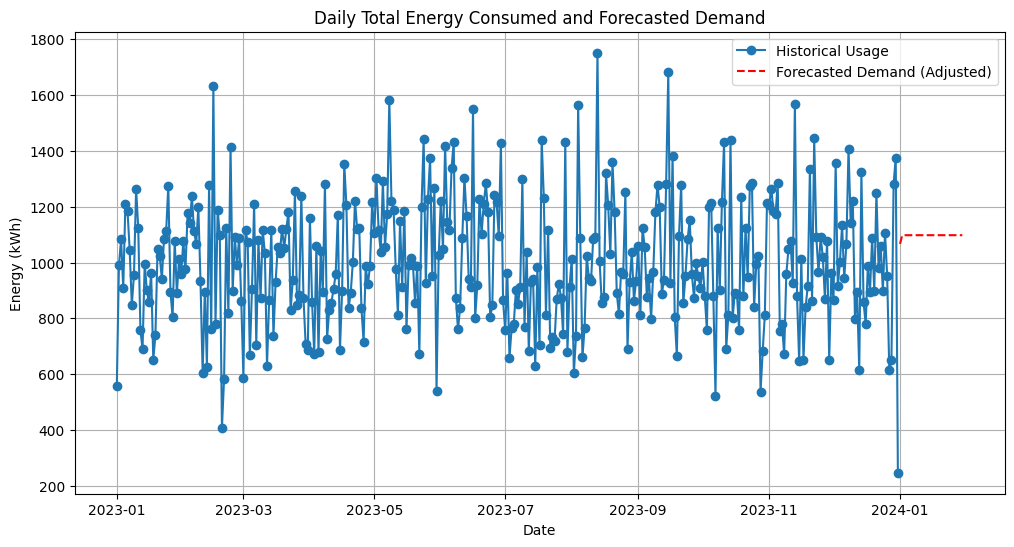

Station usage classification saved to: /Users/Sam/Downloads/station_usage_with_classification.csv
Forecasted demand saved to: /Users/Sam/Downloads/forecasted_demand.csv


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load data
file_path = '/Users/Sam/Downloads/DS_.xlsx'
df = pd.read_excel(file_path, sheet_name='DS_edited')



# Step 1: Data Preprocessing
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Date'] = df['Charging Start Time'].dt.date

# Aggregate data by Charging Station and Date
station_usage = df.groupby(['Charging Station ID', 'Date']).agg({
    'Energy Consumed (kWh)': 'sum',
    'Charging Station ID': 'count'
}).rename(columns={'Charging Station ID': 'Charging Sessions', 'Energy Consumed (kWh)': 'Total Energy Consumed'})

# Reset index for further processing
station_usage.reset_index(inplace=True)

# Step 2: Set Usage Thresholds
# Define thresholds for usage (adjust thresholds based on your business context)
OVERUSE_THRESHOLD = 300  # Example: Station energy usage > 300 kWh/day
UNDERUSE_THRESHOLD = 50  # Example: Station energy usage < 50 kWh/day

# Classify usage
station_usage['Usage Classification'] = pd.cut(
    station_usage['Total Energy Consumed'],
    bins=[-np.inf, UNDERUSE_THRESHOLD, OVERUSE_THRESHOLD, np.inf],
    labels=['Underutilized', 'Normal', 'Overutilized']
)

# Step 3: Forecast Future Demand (ARIMA Model for Total Usage)
# Aggregate total daily usage across all stations
daily_usage = station_usage.groupby('Date').agg({'Total Energy Consumed': 'sum'})
daily_usage.index = pd.to_datetime(daily_usage.index)

# Train ARIMA model
model = ARIMA(daily_usage['Total Energy Consumed'], order=(1, 1, 1))  # Example ARIMA(1,1,1)
model_fit = model.fit()

# Forecast for the next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=daily_usage.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Adjust forecast with EV growth rate (Example: 10% annual growth rate)
EV_GROWTH_RATE = 0.1
adjusted_forecast = forecast * (1 + EV_GROWTH_RATE)

# Step 4: Visualization
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Historical Usage', marker='o')
plt.plot(forecast_index, adjusted_forecast, label='Forecasted Demand (Adjusted)', color='red', linestyle='--')
plt.title('Daily Total Energy Consumed and Forecasted Demand')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# Save Results
station_usage_path = '/Users/Sam/Downloads/station_usage_with_classification.csv'
station_usage.to_csv(station_usage_path, index=False)

forecast_path = '/Users/Sam/Downloads/forecasted_demand.csv'
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecasted Demand': adjusted_forecast})
forecast_df.to_csv(forecast_path, index=False)

print(f"Station usage classification saved to: {station_usage_path}")
print(f"Forecasted demand saved to: {forecast_path}")


In [4]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 250 kB 7.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


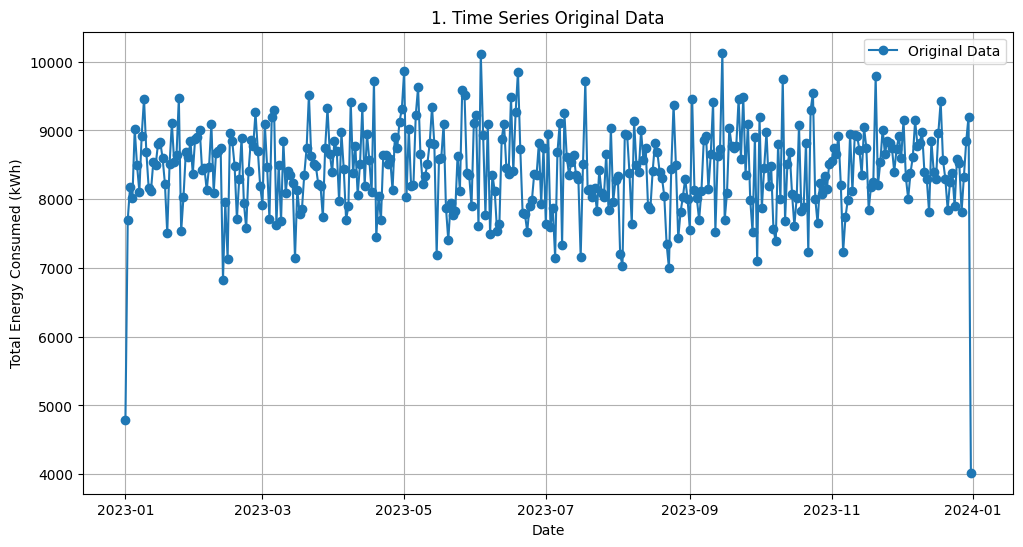

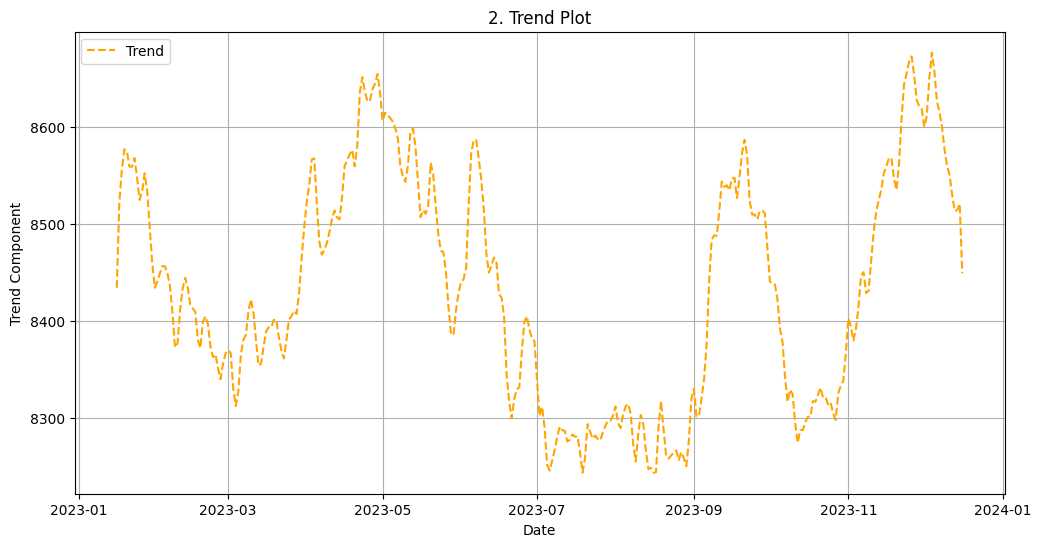

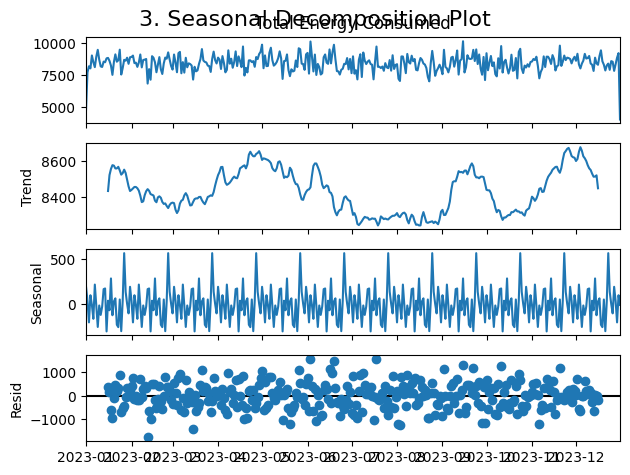

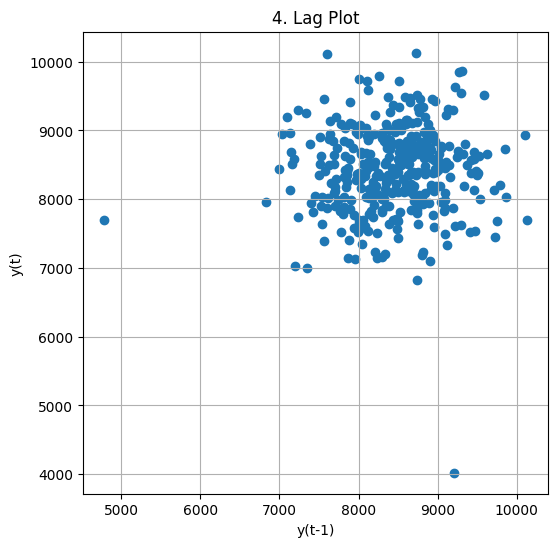

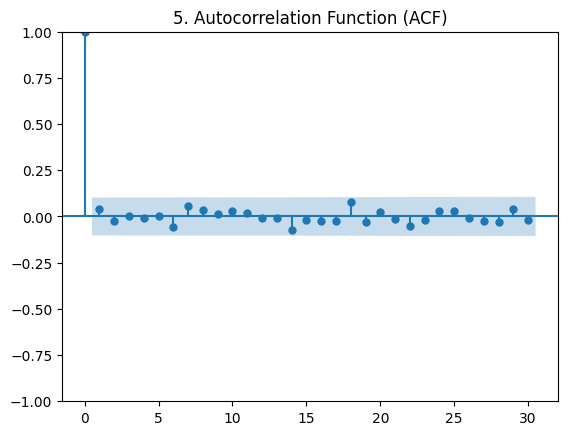

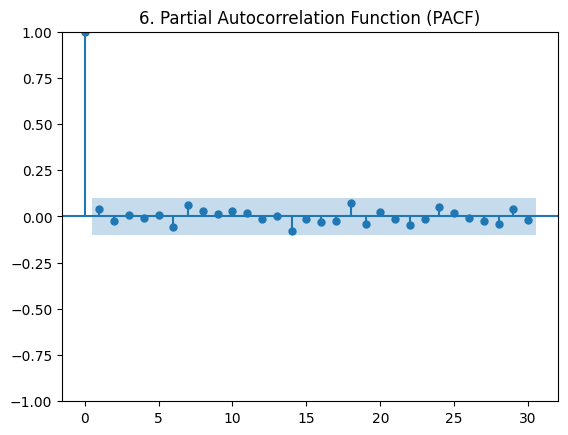

/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


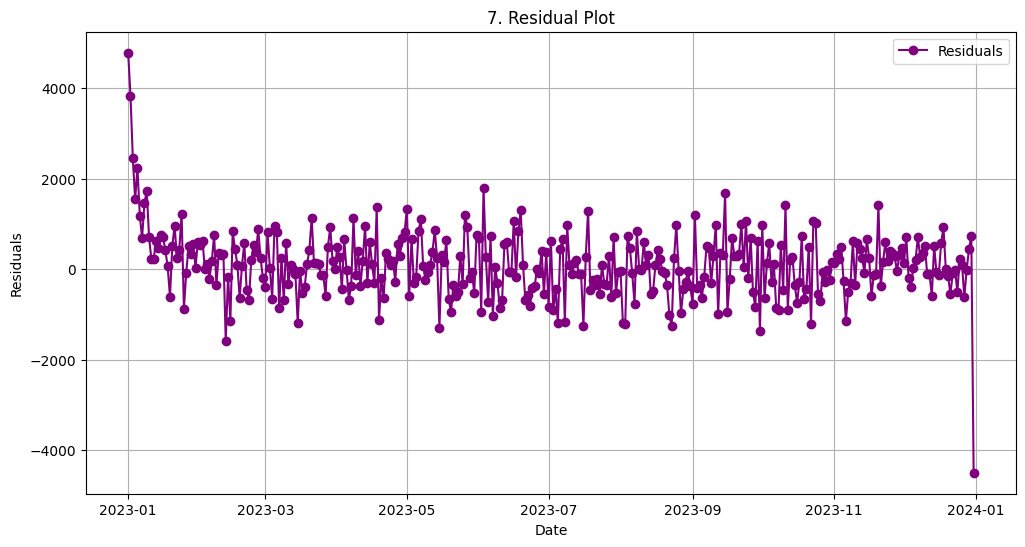

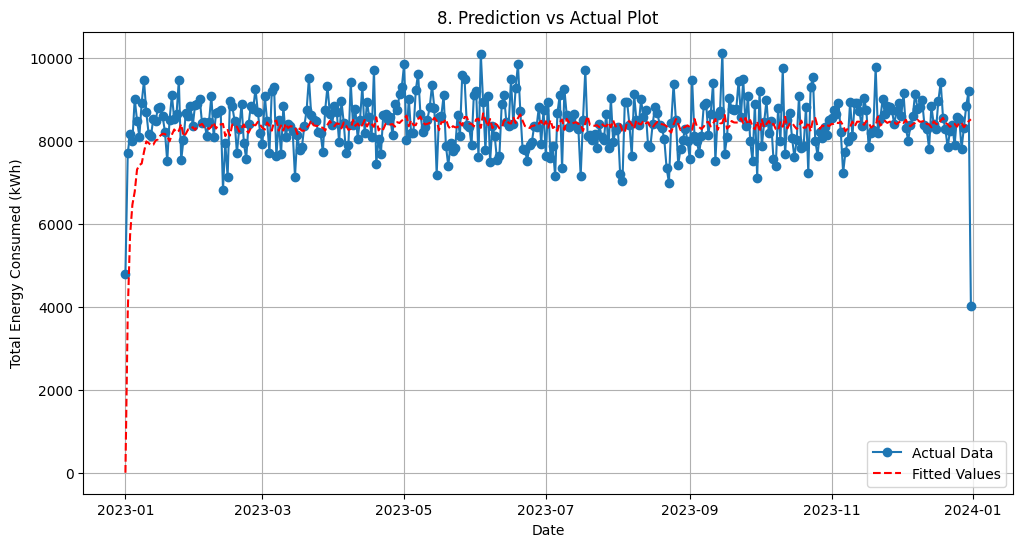

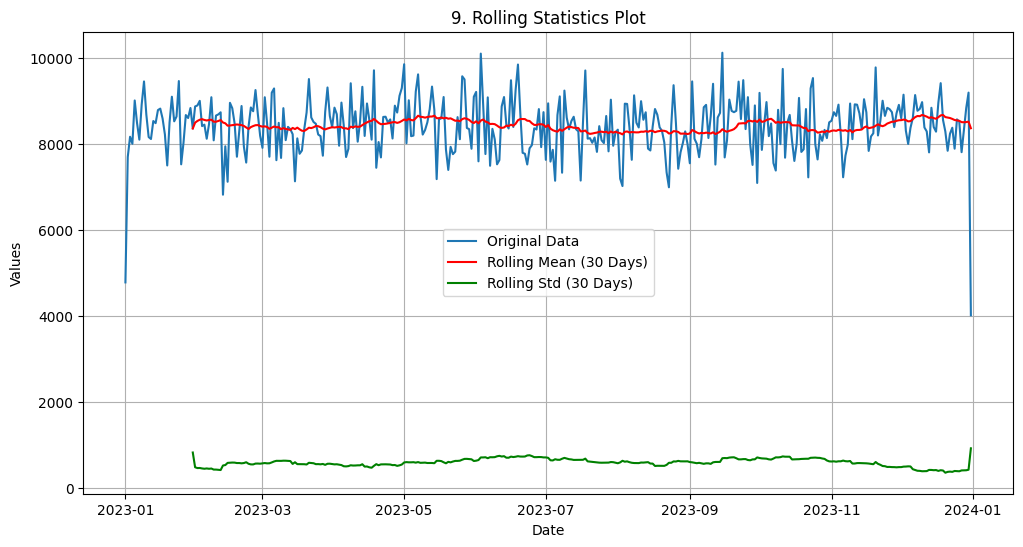

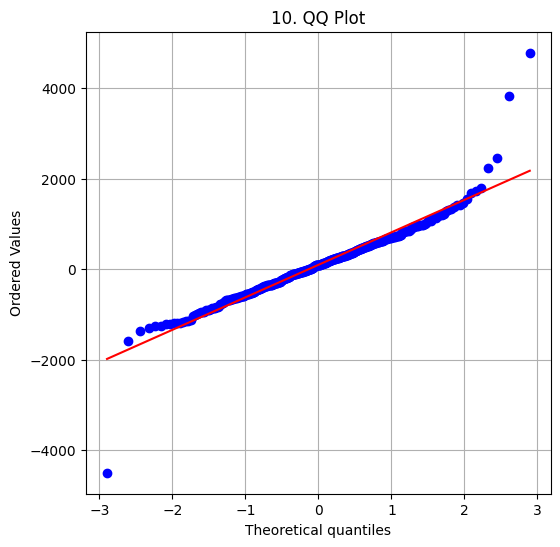

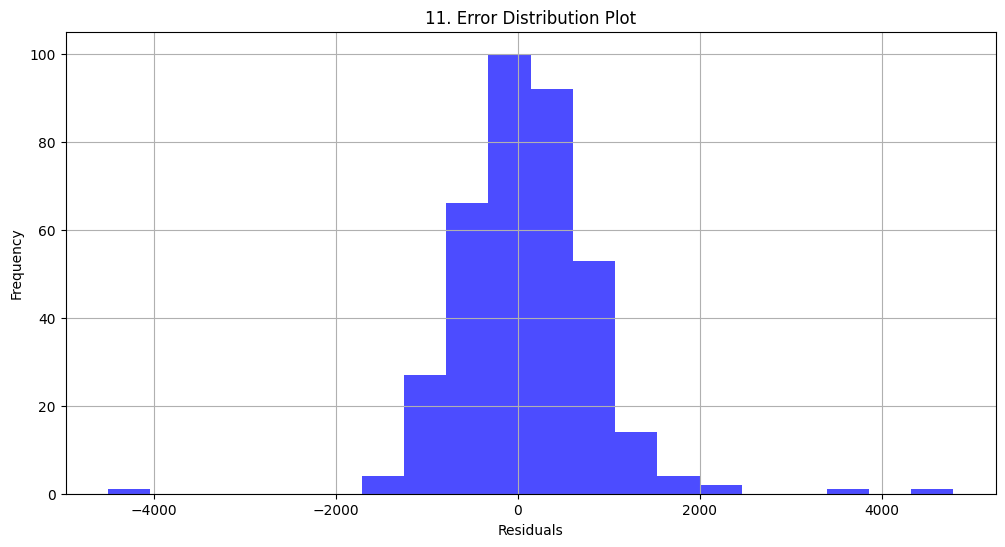

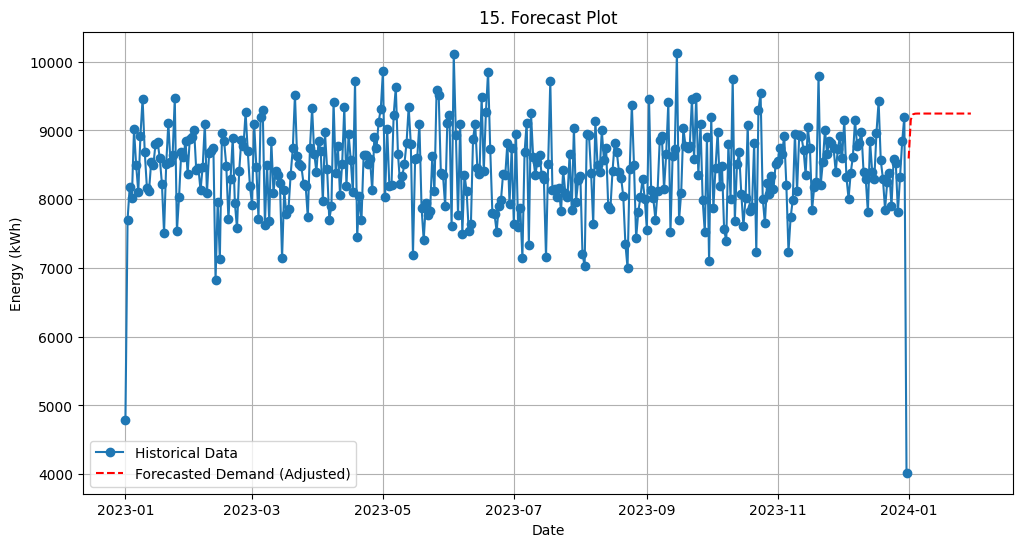

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from scipy.stats import probplot
from statsmodels.tsa.arima.model import ARIMA

# Load data
file_path = '/Users/Sam/Downloads/DS_.xlsx'
df = pd.read_excel(file_path, sheet_name='DS_edited')

# Step 1: Data Preprocessing
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Date'] = pd.to_datetime(df['Charging Start Time']).dt.date

# Aggregate total energy consumed by date
daily_usage = df.groupby('Date').agg({'Energy Consumed (kWh)': 'sum'})
daily_usage.index = pd.to_datetime(daily_usage.index)
daily_usage.rename(columns={'Energy Consumed (kWh)': 'Total Energy Consumed'}, inplace=True)

# Step 2: Decompose the time series
decomposition = seasonal_decompose(daily_usage['Total Energy Consumed'], model='additive', period=30)

# Plot 1: Original Time Series Data
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Original Data', marker='o')
plt.title('1. Time Series Original Data')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Trend Plot
plt.figure(figsize=(12, 6))
plt.plot(decomposition.trend, label='Trend', color='orange', linestyle='--')
plt.title('2. Trend Plot')
plt.xlabel('Date')
plt.ylabel('Trend Component')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Seasonal Decomposition
decomposition.plot()
plt.suptitle('3. Seasonal Decomposition Plot', fontsize=16)
plt.show()

# Plot 4: Lag Plot
plt.figure(figsize=(6, 6))
lag_plot(daily_usage['Total Energy Consumed'])
plt.title('4. Lag Plot')
plt.xlabel('y(t-1)')
plt.ylabel('y(t)')
plt.grid(True)
plt.show()

# Plot 5: Autocorrelation Function (ACF)
plot_acf(daily_usage['Total Energy Consumed'], lags=30)
plt.title('5. Autocorrelation Function (ACF)')
plt.show()

# Plot 6: Partial Autocorrelation Function (PACF)
plot_pacf(daily_usage['Total Energy Consumed'], lags=30)
plt.title('6. Partial Autocorrelation Function (PACF)')
plt.show()

# Step 3: Train ARIMA Model
model = ARIMA(daily_usage['Total Energy Consumed'], order=(1, 1, 1))
model_fit = model.fit()

# Calculate Residuals
residuals = daily_usage['Total Energy Consumed'] - model_fit.fittedvalues

# Plot 7: Residual Plot
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', marker='o', color='purple')
plt.title('7. Residual Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Plot 8: Prediction vs Actual
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Actual Data', marker='o')
plt.plot(daily_usage.index, model_fit.fittedvalues, label='Fitted Values', linestyle='--', color='red')
plt.title('8. Prediction vs Actual Plot')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 9: Rolling Statistics
rolling_mean = daily_usage['Total Energy Consumed'].rolling(window=30).mean()
rolling_std = daily_usage['Total Energy Consumed'].rolling(window=30).std()
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (30 Days)', color='red')
plt.plot(rolling_std, label='Rolling Std (30 Days)', color='green')
plt.title('9. Rolling Statistics Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot 10: QQ Plot
plt.figure(figsize=(6, 6))
probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title('10. QQ Plot')
plt.grid(True)
plt.show()

# Plot 11: Error Distribution
plt.figure(figsize=(12, 6))
residuals.hist(bins=20, alpha=0.7, color='blue')
plt.title('11. Error Distribution Plot')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 4: Forecast Future Demand
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=daily_usage.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Adjust forecast using EV growth rate
EV_GROWTH_RATE = 0.1  # Example 10% annual growth rate
adjusted_forecast = forecast * (1 + EV_GROWTH_RATE)

# Plot 15: Forecast Visualization
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Historical Data', marker='o')
plt.plot(forecast_index, adjusted_forecast, label='Forecasted Demand (Adjusted)', color='red', linestyle='--')
plt.title('15. Forecast Plot')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()


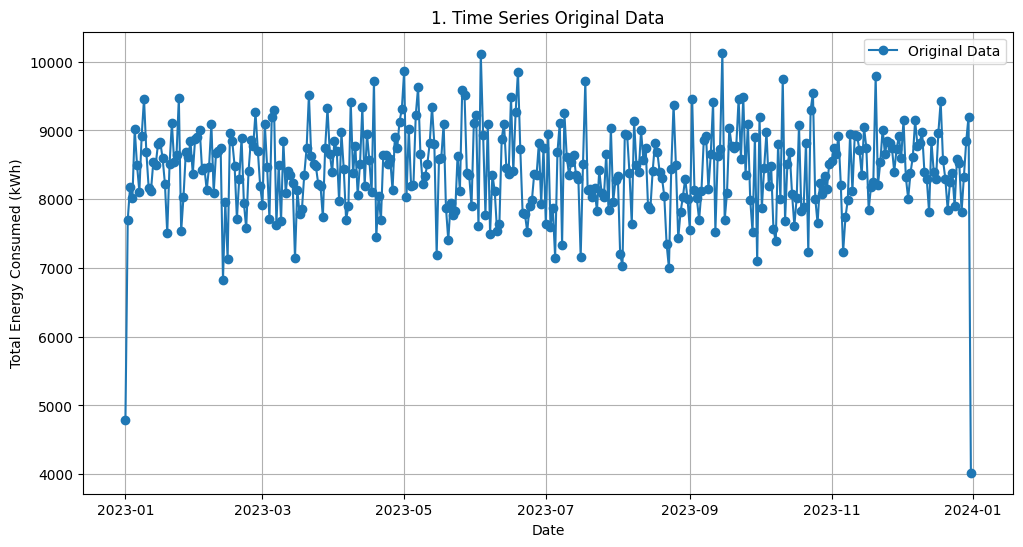

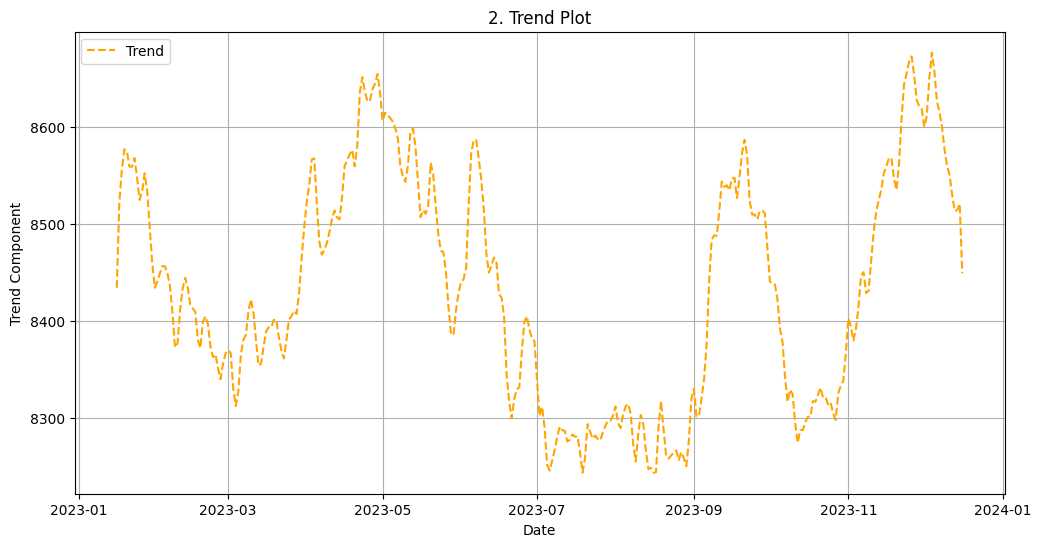

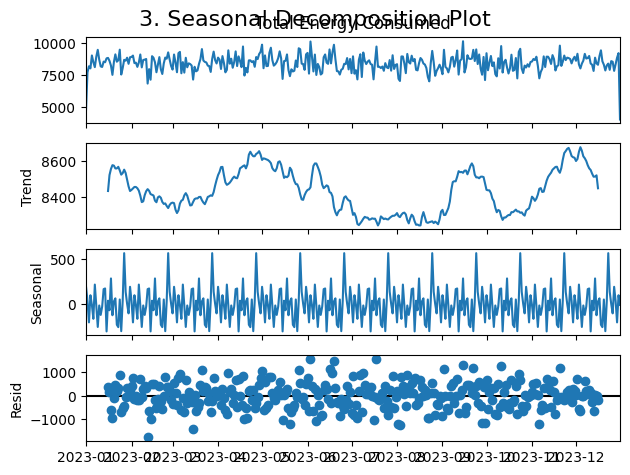

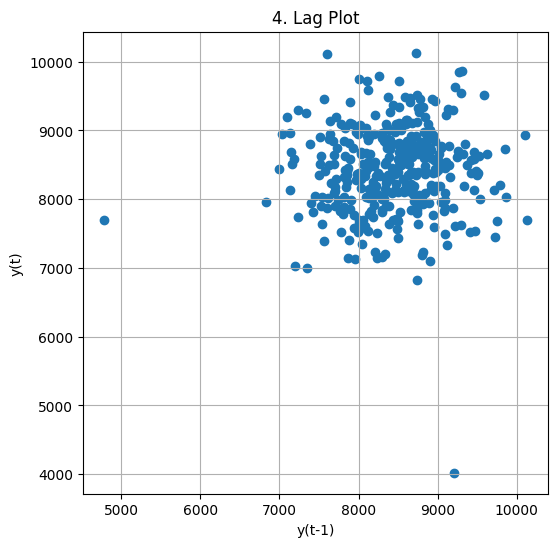

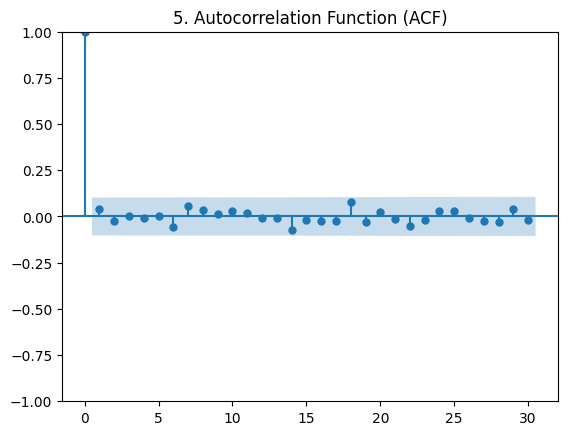

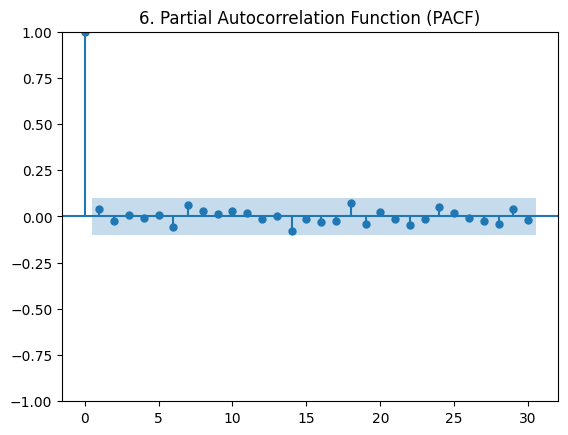

/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40641D+00    |proj g|=  5.69288D-02


 This problem is unconstrained.



At iterate    5    f=  7.37648D+00    |proj g|=  7.05667D-03

At iterate   10    f=  7.37218D+00    |proj g|=  5.02281D-03

At iterate   15    f=  7.37160D+00    |proj g|=  6.68134D-04

At iterate   20    f=  7.36593D+00    |proj g|=  1.46562D-02

At iterate   25    f=  7.36129D+00    |proj g|=  1.96631D-03

At iterate   30    f=  7.36115D+00    |proj g|=  6.94706D-03

At iterate   35    f=  7.34586D+00    |proj g|=  9.49312D-02

At iterate   40    f=  7.27893D+00    |proj g|=  8.97320D-03

At iterate   45    f=  7.27102D+00    |proj g|=  6.63120D-04

At iterate   50    f=  7.27087D+00    |proj g|=  2.82926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


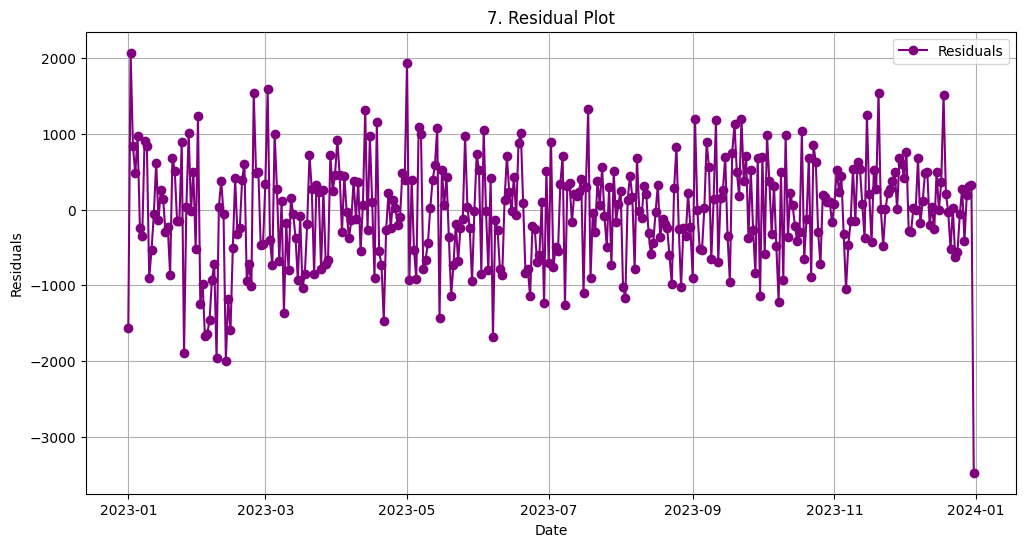

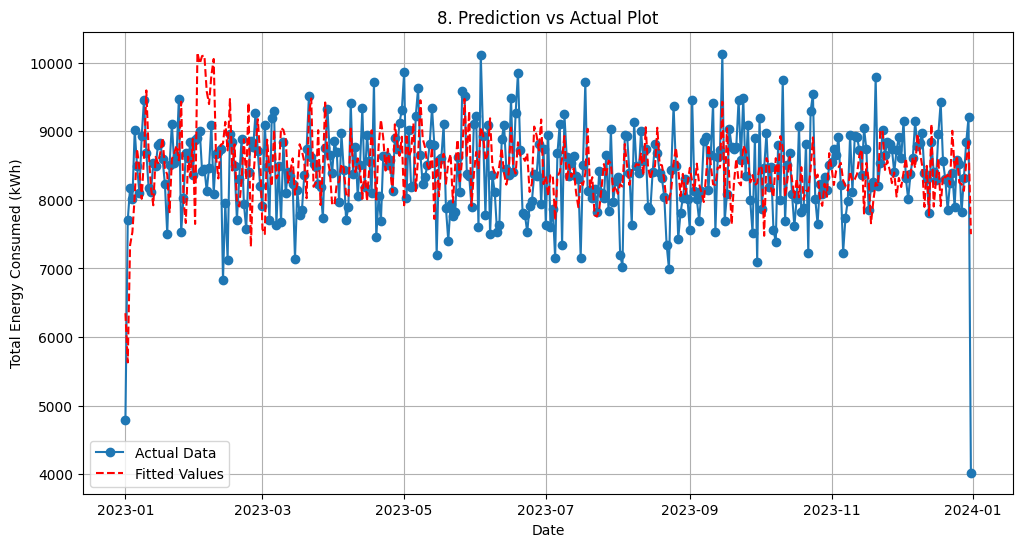

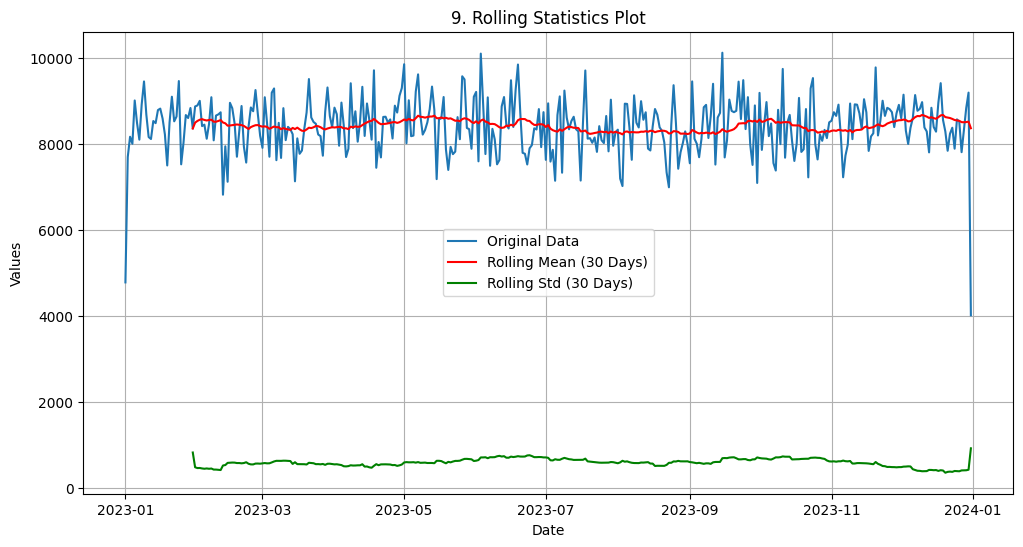

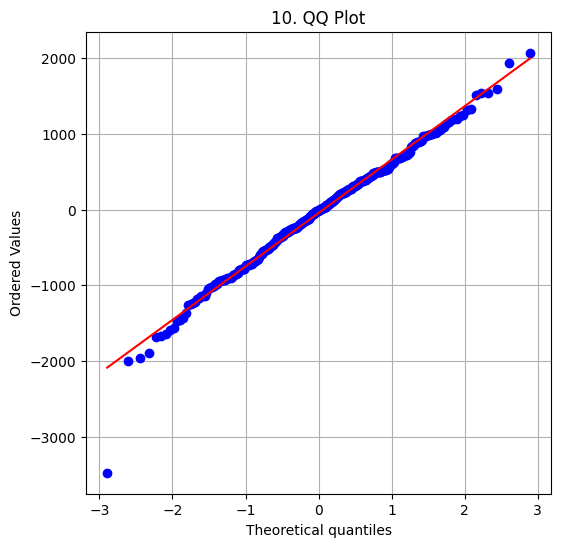

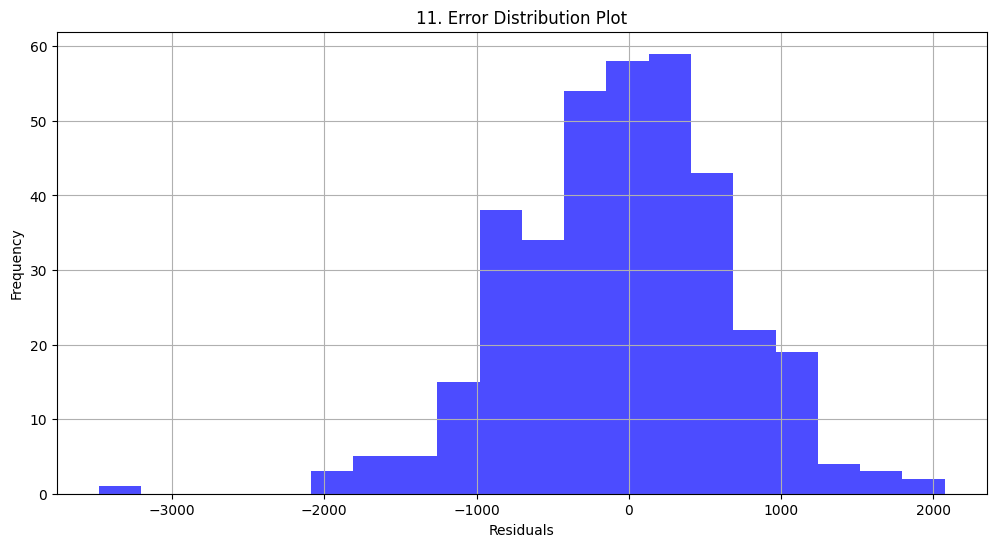

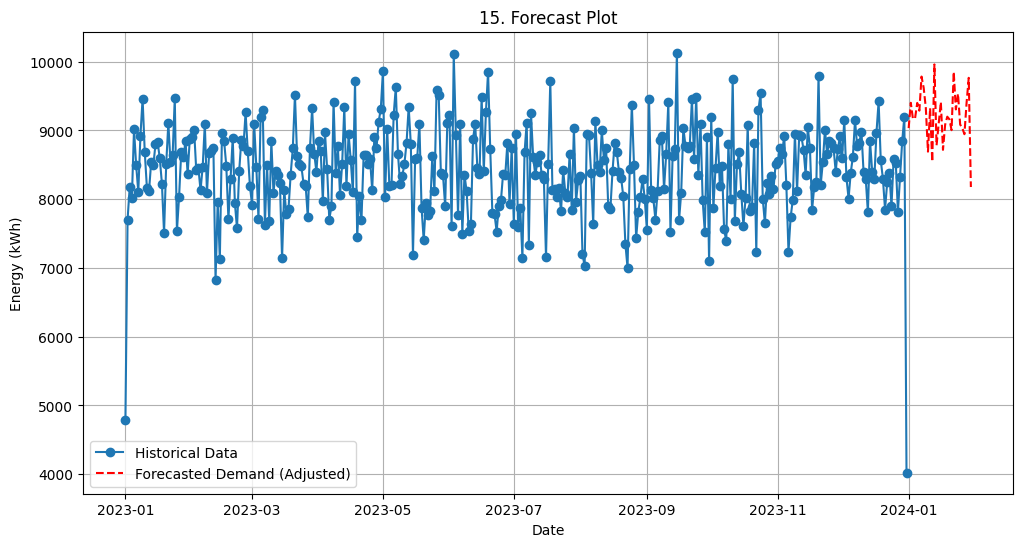

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from scipy.stats import probplot
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load data
file_path = '/Users/Sam/Downloads/DS_.xlsx'
df = pd.read_excel(file_path, sheet_name='DS_edited')

# Step 1: Data Preprocessing
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Date'] = pd.to_datetime(df['Charging Start Time']).dt.date

# Aggregate data by date with additional features
daily_usage = df.groupby('Date').agg({
    'Energy Consumed (kWh)': 'sum',
    'Weather (Â°C)': 'mean',
    'Charging Station ID': 'count',  # Charging sessions
    'Efficiency (km/kwh)': 'mean'
}).rename(columns={
    'Energy Consumed (kWh)': 'Total Energy Consumed',
    'Weather (Â°C)': 'Average Weather',
    'Charging Station ID': 'Charging Sessions',
    'Efficiency (km/kwh)': 'Average Efficiency'
})

daily_usage.index = pd.to_datetime(daily_usage.index)

# Step 2: Decompose the time series
decomposition = seasonal_decompose(daily_usage['Total Energy Consumed'], model='additive', period=30)

# Plot original data and decompositions
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Original Data', marker='o')
plt.title('1. Time Series Original Data')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed (kWh)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(decomposition.trend, label='Trend', color='orange', linestyle='--')
plt.title('2. Trend Plot')
plt.xlabel('Date')
plt.ylabel('Trend Component')
plt.legend()
plt.grid(True)
plt.show()

decomposition.plot()
plt.suptitle('3. Seasonal Decomposition Plot', fontsize=16)
plt.show()

plt.figure(figsize=(6, 6))
lag_plot(daily_usage['Total Energy Consumed'])
plt.title('4. Lag Plot')
plt.xlabel('y(t-1)')
plt.ylabel('y(t)')
plt.grid(True)
plt.show()

plot_acf(daily_usage['Total Energy Consumed'], lags=30)
plt.title('5. Autocorrelation Function (ACF)')
plt.show()

plot_pacf(daily_usage['Total Energy Consumed'], lags=30)
plt.title('6. Partial Autocorrelation Function (PACF)')
plt.show()

# Step 3: Train SARIMAX Model with Additional Features
exog_features = daily_usage[['Average Weather', 'Charging Sessions', 'Average Efficiency']]
model = SARIMAX(
    daily_usage['Total Energy Consumed'],
    exog=exog_features,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 30)
)
model_fit = model.fit()

# Calculate residuals
residuals = daily_usage['Total Energy Consumed'] - model_fit.fittedvalues

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', marker='o', color='purple')
plt.title('7. Residual Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Actual Data', marker='o')
plt.plot(daily_usage.index, model_fit.fittedvalues, label='Fitted Values', linestyle='--', color='red')
plt.title('8. Prediction vs Actual Plot')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed (kWh)')
plt.legend()
plt.grid(True)
plt.show()

rolling_mean = daily_usage['Total Energy Consumed'].rolling(window=30).mean()
rolling_std = daily_usage['Total Energy Consumed'].rolling(window=30).std()
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (30 Days)', color='red')
plt.plot(rolling_std, label='Rolling Std (30 Days)', color='green')
plt.title('9. Rolling Statistics Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title('10. QQ Plot')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
residuals.hist(bins=20, alpha=0.7, color='blue')
plt.title('11. Error Distribution Plot')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 4: Forecast Future Demand
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps, exog=exog_features.iloc[-forecast_steps:])
forecast_index = pd.date_range(start=daily_usage.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

EV_GROWTH_RATE = 0.1  # Example growth rate
adjusted_forecast = forecast * (1 + EV_GROWTH_RATE)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Historical Data', marker='o')
plt.plot(forecast_index, adjusted_forecast, label='Forecasted Demand (Adjusted)', color='red', linestyle='--')
plt.title('15. Forecast Plot')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

# Load data
file_path = '/Users/Sam/Downloads/DS_.xlsx'
df = pd.read_excel(file_path, sheet_name='DS_edited')

# Step 1: Data Preprocessing
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Date'] = pd.to_datetime(df['Charging Start Time']).dt.date

# Aggregate data by Charging Station and Date with additional features
station_usage = df.groupby(['Charging Station ID', 'Date']).agg({
    'Energy Consumed (kWh)': 'sum',
    'Charging Station ID': 'count',
    'Distance Driven Per Day (km)': 'mean',
    'Weather (Â°C)': 'mean',
    'Energy Usage Per Day (kWh/day)': 'mean',
    'Charger Type': 'first'  # Assuming charger type remains constant for each station
}).rename(columns={
    'Energy Consumed (kWh)': 'Total Energy Consumed',
    'Charging Station ID': 'Charging Sessions',
    'Distance Driven Per Day (km)': 'Average Distance Driven',
    'Weather (Â°C)': 'Average Weather',
    'Energy Usage Per Day (kWh/day)': 'Average Energy Usage',
    'Charger Type': 'Charger Type'
})

# Reset index for further processing
station_usage.reset_index(inplace=True)

# Step 2: Set Usage Thresholds
OVERUSE_THRESHOLD = 300  # Example: Station energy usage > 300 kWh/day
UNDERUSE_THRESHOLD = 50  # Example: Station energy usage < 50 kWh/day

# Classify usage
station_usage['Usage Classification'] = pd.cut(
    station_usage['Total Energy Consumed'],
    bins=[-np.inf, UNDERUSE_THRESHOLD, OVERUSE_THRESHOLD, np.inf],
    labels=['Underutilized', 'Normal', 'Overutilized']
)

# Step 3: Forecast Future Demand (ARIMA or SARIMAX Model for Total Usage)
# Aggregate total daily usage across all stations
daily_usage = station_usage.groupby('Date').agg({'Total Energy Consumed': 'sum'})
daily_usage.index = pd.to_datetime(daily_usage.index)

# Train SARIMAX model using additional features
exog_features = station_usage[['Average Weather', 'Average Distance Driven', 'Average Energy Usage']]
model = SARIMAX(
    daily_usage['Total Energy Consumed'],
    exog=exog_features.groupby('Date').agg('mean'),
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 30)  # Assuming daily seasonal behavior
)
model_fit = model.fit()

# Forecast for the next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps, exog=exog_features.iloc[-forecast_steps:])
forecast_index = pd.date_range(start=daily_usage.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Adjust forecast with EV growth rate (Example: 10% annual growth rate)
EV_GROWTH_RATE = 0.1
adjusted_forecast = forecast * (1 + EV_GROWTH_RATE)

# Step 4: Visualizations

# Plot 1: Time Series Original Data
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Original Data', marker='o')
plt.title('1. Time Series Original Data')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Trend Plot
plt.figure(figsize=(12, 6))
decomposition = seasonal_decompose(daily_usage['Total Energy Consumed'], model='additive', period=30)
plt.plot(decomposition.trend, label='Trend', color='orange', linestyle='--')
plt.title('2. Trend Plot')
plt.xlabel('Date')
plt.ylabel('Trend Component')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Seasonal Decomposition
decomposition.plot()
plt.suptitle('3. Seasonal Decomposition Plot', fontsize=16)
plt.show()

# Plot 4: Lag Plot
plt.figure(figsize=(6, 6))
lag_plot(daily_usage['Total Energy Consumed'])
plt.title('4. Lag Plot')
plt.xlabel('y(t-1)')
plt.ylabel('y(t)')
plt.grid(True)
plt.show()

# Plot 5: Autocorrelation Function (ACF)
plot_acf(daily_usage['Total Energy Consumed'], lags=30)
plt.title('5. Autocorrelation Function (ACF)')
plt.show()

# Plot 6: Partial Autocorrelation Function (PACF)
plot_pacf(daily_usage['Total Energy Consumed'], lags=30)
plt.title('6. Partial Autocorrelation Function (PACF)')
plt.show()

# Plot 7: Residual Plot
residuals = daily_usage['Total Energy Consumed'] - model_fit.fittedvalues
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', marker='o', color='purple')
plt.title('7. Residual Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Plot 8: Prediction vs Actual Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Actual Data', marker='o')
plt.plot(daily_usage.index, model_fit.fittedvalues, label='Fitted Values', linestyle='--', color='red')
plt.title('8. Prediction vs Actual Plot')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 9: Rolling Statistics
rolling_mean = daily_usage['Total Energy Consumed'].rolling(window=30).mean()
rolling_std = daily_usage['Total Energy Consumed'].rolling(window=30).std()
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (30 Days)', color='red')
plt.plot(rolling_std, label='Rolling Std (30 Days)', color='green')
plt.title('9. Rolling Statistics Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot 10: QQ Plot
plt.figure(figsize=(6, 6))
probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title('10. QQ Plot')
plt.grid(True)
plt.show()

# Plot 11: Error Distribution Plot
plt.figure(figsize=(12, 6))
residuals.hist(bins=20, alpha=0.7, color='blue')
plt.title('11. Error Distribution Plot')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 15: Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_usage['Total Energy Consumed'], label='Historical Data', marker='o')
plt.plot(forecast_index, adjusted_forecast, label='Forecasted Demand (Adjusted)', color='red', linestyle='--')
plt.title('15. Forecast Plot')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# Save Results
station_usage_path = '/Users/Sam/Downloads/station_usage_with_classification.csv'
station_usage.to_csv(station_usage_path, index=False)

forecast_path = '/Users/Sam/Downloads/forecasted_demand.csv'
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecasted Demand': adjusted_forecast})
forecast_df.to_csv(forecast_path, index=False)

print(f"Station usage classification saved to: {station_usage_path}")
print(f"Forecasted demand saved to: {forecast_path}")


KeyError: 'Date'